# Expedia Booking – Feature Creation & Evaluation
**Goal:** quickly build candidate features and evaluate how much they improve the prediction of `booking_bool`.

This notebook has two clear sections:
1. **Create candidate features** (adds new columns, writes them to CSV)
2. **Test those features** (merges with base data, trains fast model, reports performance delta)


## 🔧 Paths & parameters

In [3]:
TRAIN_CSV = '/Users/nikak/Desktop/vubaby/DMT/DMT/assignment_2/train_imputed.pkl'  # <- change me
OUT_FEAT_CSV = 'nika_candidate_feats.csv'           # file to write new features
SAMPLE_FRAC = 0.02                             # 2% sample for fast testing

FINAL_TEST_CSV = '/Users/nikak/Desktop/vubaby/DMT/DMT/assignment_2/test_imputed.pkl'  # <- change me

## 1️⃣ Create candidate features NEW

In [6]:
import pandas as pd
import numpy as np

# ------------------------------------------------------------------
#              FEATURE-ENGINEERING FUNCTIONS
# ------------------------------------------------------------------

def within_search_features(df):
    df['price_rank'] = df.groupby('srch_id')['price_usd'].rank(method='min')
    df['star_rank_pct'] = df.groupby('srch_id')['prop_starrating'] \
                            .rank(pct=True, ascending=False)
    return df

def value_for_money(df):
    df['value_score'] = df['prop_review_score'] / (df['price_usd'] + 1e-3)
    return df

def price_relative_features(df):
    med_price = df.groupby('srch_id')['price_usd'].transform('median')
    df['price_rel_search_rank'] = (df['price_usd'] / (med_price + 1e-3)) \
                                    .groupby(df['srch_id']).rank(pct=True)
    return df

def star_relative_to_search(df):
    mean_stars = df.groupby('srch_id')['prop_starrating'].transform('mean')
    df['star_diff_search'] = df['prop_starrating'] - mean_stars
    return df

def review_relative_to_search(df):
    mean_rev = df.groupby('srch_id')['prop_review_score'].transform('mean')
    df['review_diff_search'] = df['prop_review_score'] - mean_rev
    return df

def residual_price(df):
    mean_prop = df.groupby('prop_id')['price_usd'].transform('mean')
    df['residual_price'] = df['price_usd'] - mean_prop
    return df

def property_popularity(df, smoothing=10):
    stats = df.groupby('prop_id')['booking_bool'] \
              .agg(bookings='sum', imps='count')
    global_rate = df['booking_bool'].mean()
    stats['prop_popularity'] = (stats['bookings'] + smoothing * global_rate) \
                              / (stats['imps'] + smoothing)
    return df.merge(stats[['prop_popularity']], on='prop_id', how='left')

def destination_popularity(df, smoothing=20):
    stats = df.groupby('srch_destination_id')['booking_bool'] \
              .agg(bookings='sum', imps='count')
    global_rate = df['booking_bool'].mean()
    stats['dest_popularity'] = (stats['bookings'] + smoothing * global_rate) \
                              / (stats['imps'] + smoothing)
    return df.merge(stats[['dest_popularity']], on='srch_destination_id', how='left')

def location_score_gap(df):
    mean_loc1 = df.groupby('srch_id')['prop_location_score1'].transform('mean')
    df['location_score_gap'] = df['prop_location_score1'] - mean_loc1
    return df

def location_score2_gap(df):
    mean_loc2 = df.groupby('srch_id')['prop_location_score2'].transform('mean')
    df['location_score2_gap'] = df['prop_location_score2'] - mean_loc2
    return df

def cross_cheap_and_good(df):
    df['cheap_and_good'] = df['price_rank'] * df['star_diff_search']
    return df

def search_size(df):
    df['search_size'] = df.groupby('srch_id')['prop_id'].transform('count')
    return df

def nightly_price_features(df):
    df['price_per_night'] = df['price_usd'] / (df['srch_length_of_stay'] + 1e-3)
    med_nightly = df.groupby('srch_id')['price_per_night'].transform('median')
    df['price_per_night_rel'] = df['price_per_night'] / (med_nightly + 1e-3)
    return df

# ------------------------------------------------------------------
#              LOAD ONLY THE NEEDED COLUMNS
# ------------------------------------------------------------------
base_cols = [
    'srch_id', 'prop_id',
    'price_usd', 'prop_starrating', 'prop_review_score',
    'srch_length_of_stay', 'srch_destination_id',
    'prop_location_score1', 'prop_location_score2',
    'booking_bool'
]
# df_raw = pd.read_csv(TRAIN_CSV, usecols=base_cols)
df_raw = pd.read_pickle(TRAIN_CSV)[base_cols]
test = pd.read_pickle(FINAL_TEST_CSV) 

# ------------------------------------------------------------------
#              APPLY FEATURE FUNCTIONS
# ------------------------------------------------------------------
feature_funcs = [
    within_search_features,
    value_for_money,
    price_relative_features,
    star_relative_to_search,
    review_relative_to_search,
    residual_price,
    property_popularity,
    destination_popularity,
    location_score_gap,
    location_score2_gap,
    cross_cheap_and_good,
    search_size,
    nightly_price_features
]


# for the test set I have to remove the property popularity and destination popularity because they use 
# the booking_bool column which is not available in the test set
feature_funcs_test = [
        within_search_features,
    value_for_money,
    price_relative_features,
    star_relative_to_search,
    review_relative_to_search,
    residual_price,
    location_score_gap,
    location_score2_gap,
    cross_cheap_and_good,
    search_size,
    nightly_price_features
]

for func in feature_funcs:
    df_raw = func(df_raw)
    
for func in feature_funcs_test:
    test = func(test)

# ------------------------------------------------------------------
#              SELECT & SAVE OUTPUT
# ------------------------------------------------------------------
keep = [
    'srch_id', 'prop_id',
    'srch_destination_id', #<----- I added this for destination popularity
    'price_rank', 'star_rank_pct', 'value_score',
    'price_rel_search_rank',
    'star_diff_search', 'review_diff_search',
    'residual_price',
    'prop_popularity', 'dest_popularity',
    'location_score_gap', 'location_score2_gap',
    'cheap_and_good', 'search_size',
    'price_per_night', 'price_per_night_rel'
]

df_raw[keep].to_csv(OUT_FEAT_CSV, index=False)
print('📝 wrote', OUT_FEAT_CSV)

keep_test = [c for c in keep if c not in ['prop_popularity', 'dest_popularity']]
test[keep_test].to_csv("nika_candidate_feats_test.csv", index=False)
print('📝 wrote nika_candidate_feats_test.csv')


📝 wrote nika_candidate_feats.csv
📝 wrote nika_candidate_feats_test.csv


## 2️⃣ Evaluate candidate features

In [5]:
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
import pandas as pd
import lightgbm as lgb
import shap

# Config blocks
LEAKS = ['position', 'gross_bookings_usd']
REMOVE_COLS = []  # ADD COLUMNS WE WANT TO DROP FROM THE DATASET
LABEL_CLICK, LABEL_BOOK = 'click_bool', 'booking_bool'


def engineer_light(df):
    df = df.copy()
    num_cols = df.select_dtypes('number').columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())
    df['price_per_star'] = df['price_usd'] / (df['prop_starrating'] + 0.5)
    df['intl_trip'] = (df['visitor_location_country_id'] != df['prop_country_id']).astype('int8')
    return df

# Load full training set
df_full = pd.read_pickle(TRAIN_CSV)
df_full = engineer_light(df_full)

y = df_full[LABEL_BOOK]
drop_cols = [LABEL_CLICK, LABEL_BOOK] + LEAKS + ['date_time']
X_base = df_full.drop(columns=drop_cols)

# 🔥 New line to drop additional unwanted columns
X_base = X_base.drop(columns=[col for col in REMOVE_COLS if col in X_base.columns])

# Merge candidate features
cand = pd.read_csv(OUT_FEAT_CSV)
X_full = X_base.merge(cand, on=['srch_id', 'prop_id', 'srch_destination_id' ], how='left') # <--- I also added 'srch_destination_id' here
new_cols = [c for c in cand.columns if c not in ['srch_id', 'prop_id']]

# Sample for speed
X_full = X_full.sample(frac=SAMPLE_FRAC, random_state=42)
y = y.loc[X_full.index]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.3, random_state=42, stratify=y
)

# Train LightGBM model
train_data = lgb.Dataset(X_train.fillna(0), label=y_train)
test_data = lgb.Dataset(X_test.fillna(0), label=y_test, reference=train_data)

params = {
    'objective': 'binary',
    'metric': ['auc', 'binary_logloss'],
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'n_jobs': -1,
    'seed': 42
}

print("Training LightGBM model...")
model = lgb.train(
    params,
    train_data,
    num_boost_round=50,
    valid_sets=[test_data],
)

# Evaluate model
preds = model.predict(X_test.fillna(0))
auc = roc_auc_score(y_test, preds)
ll = log_loss(y_test, preds)
print(f"LightGBM AUC: {auc:.4f}  |  LogLoss: {ll:.4f}")

# SHAP analysis (no plotting here)
print("\nComputing SHAP values for all new features...")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test.fillna(0))

# Store SHAP values for new candidate features only
shap_df = pd.DataFrame(shap_values, columns=X_test.columns, index=X_test.index)
shap_new_feats = shap_df[new_cols].copy()
print("Computed SHAP values for:", list(shap_new_feats.columns))


Training LightGBM model...
LightGBM AUC: 0.8603  |  LogLoss: 0.1033

Computing SHAP values for all new features...
Computed SHAP values for: ['srch_destination_id', 'price_rank', 'star_rank_pct', 'value_score', 'price_rel_search_rank', 'star_diff_search', 'review_diff_search', 'residual_price', 'prop_popularity', 'dest_popularity', 'location_score_gap', 'location_score2_gap', 'cheap_and_good', 'search_size', 'price_per_night', 'price_per_night_rel']


c:\Users\nikak\Desktop\vubaby\DMT\DMT\.venv\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



🔎 SHAP summary plot for candidate features:


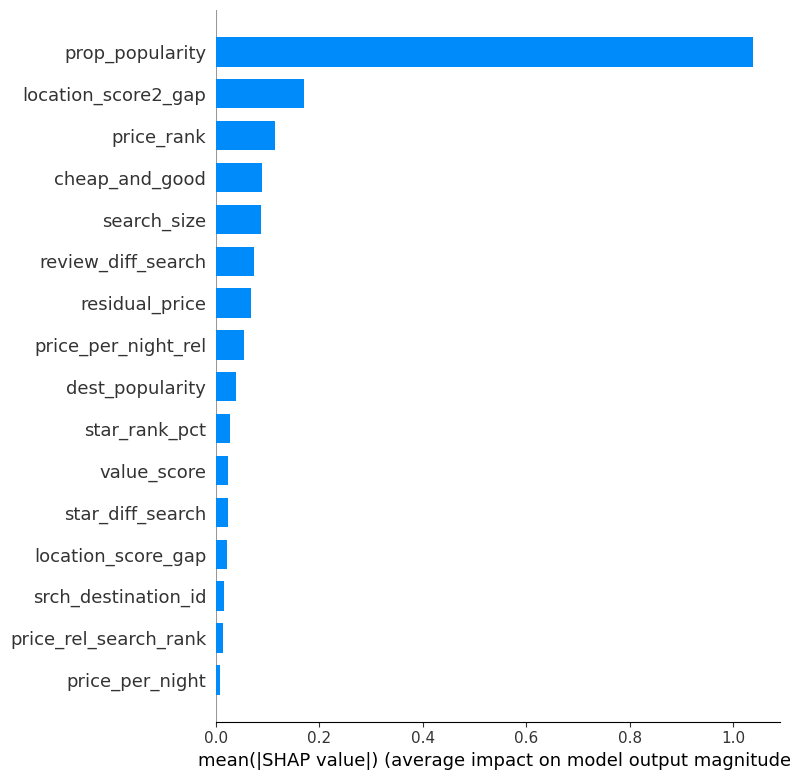


🐝 Detailed SHAP beeswarm plot for candidate features:


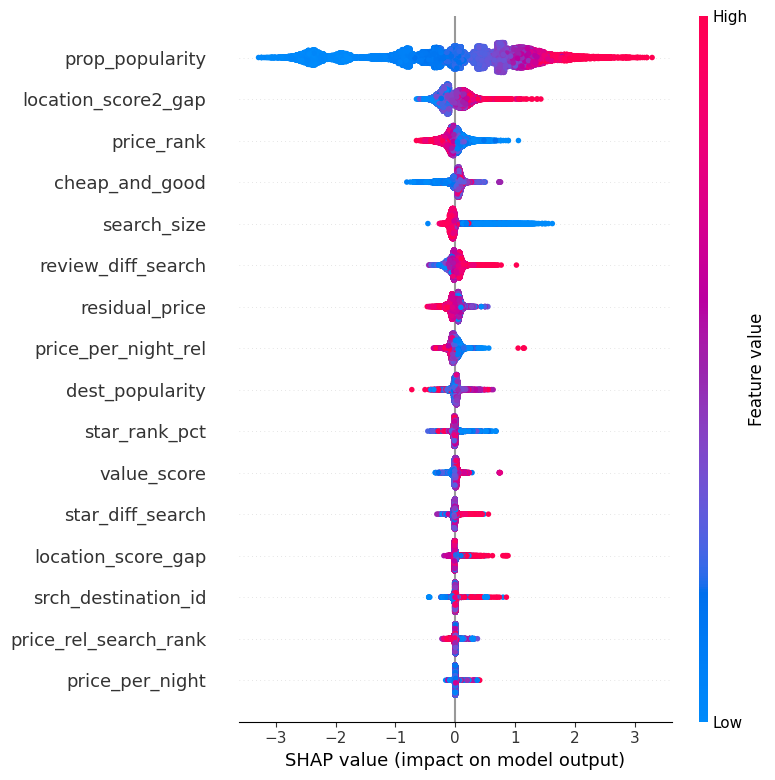

In [6]:
import matplotlib.pyplot as plt
import shap
# Summary plot of candidate features only
print("\n🔎 SHAP summary plot for candidate features:")

shap.summary_plot(
    shap_new_feats.values,  # Only new feature SHAP values
    X_test[new_cols],        # Only new feature data
    feature_names=new_cols,
    max_display=len(new_cols),  # Show all candidates
    plot_type="bar"            # Start with a simple bar chart
)

# Optional: Detailed beeswarm plot
print("\n🐝 Detailed SHAP beeswarm plot for candidate features:")
shap.summary_plot(
    shap_new_feats.values,
    X_test[new_cols],
    feature_names=new_cols,
    max_display=len(new_cols),
    plot_type="dot"   # Traditional SHAP beeswarm
)



📊 Full SHAP overview (highlighting candidate features):


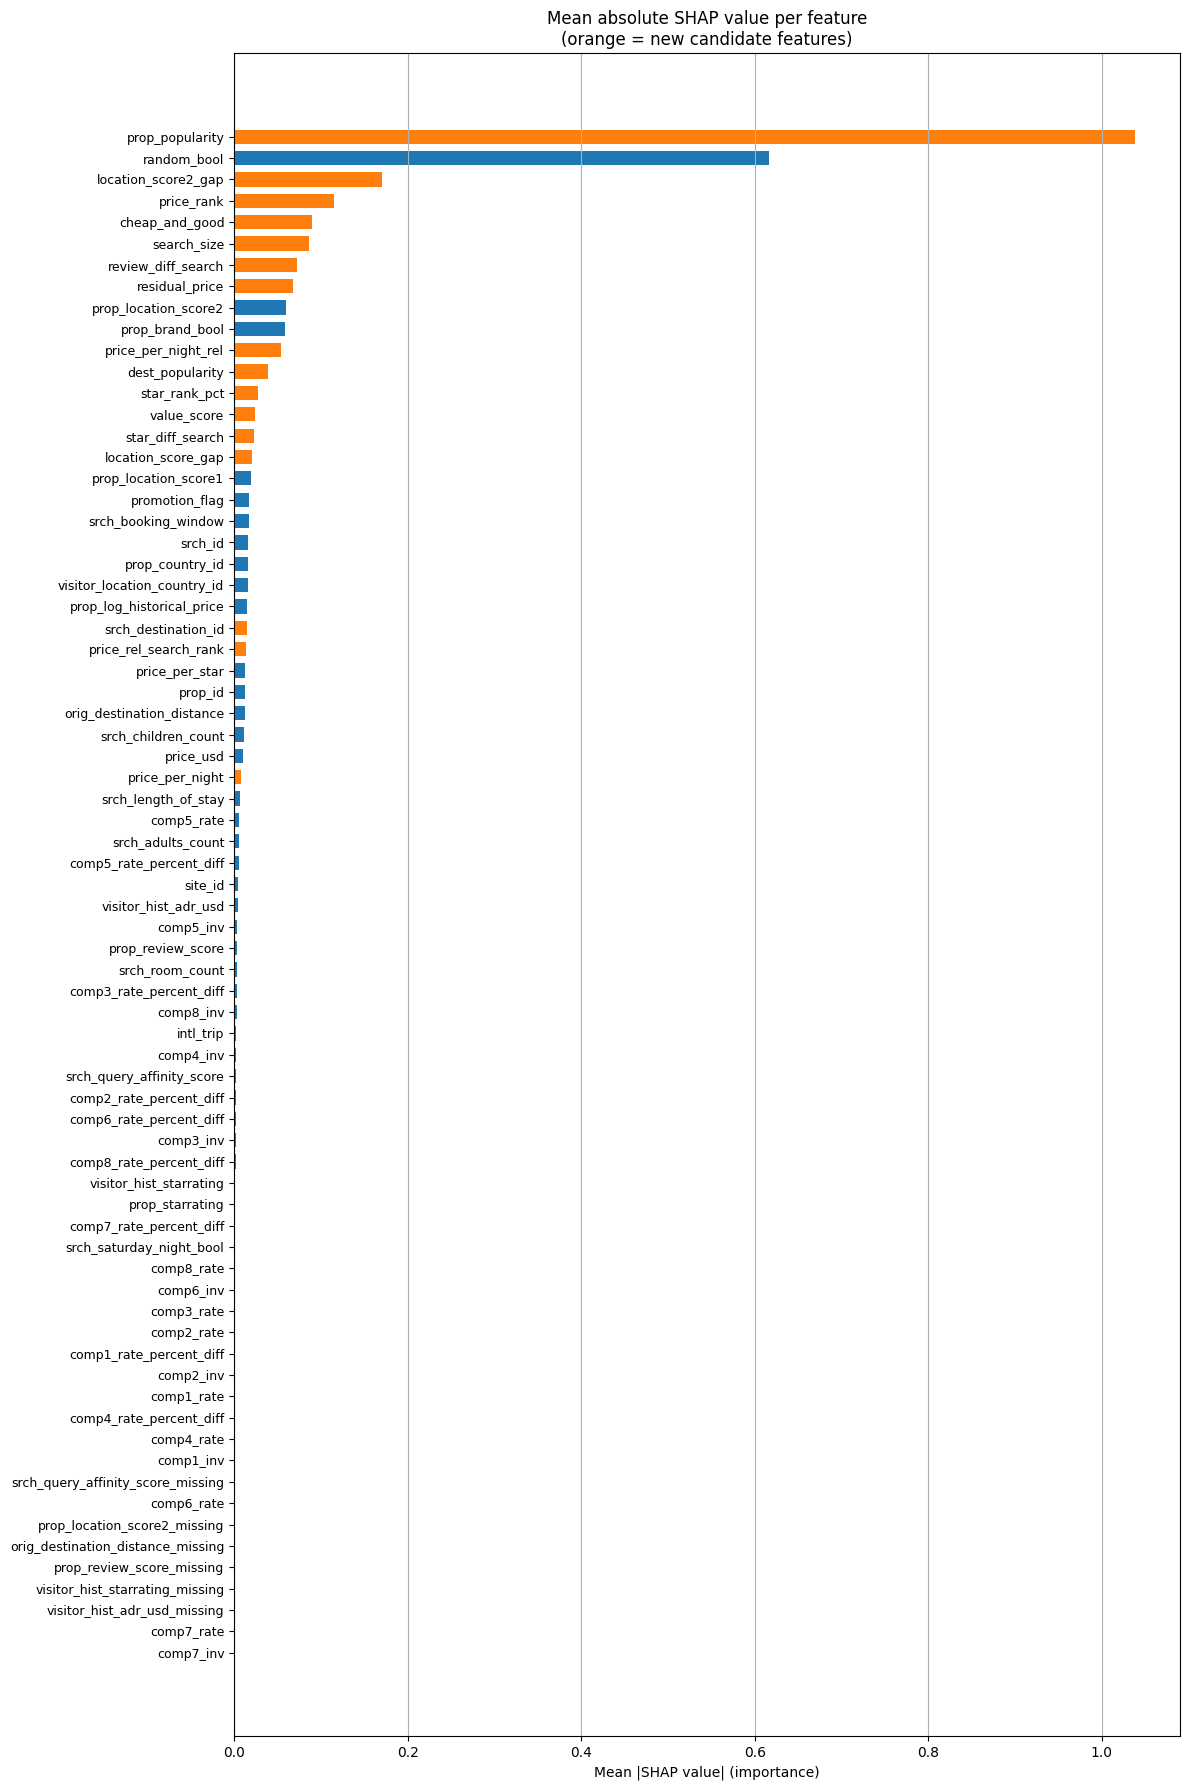

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Full SHAP values (all features)
print("\n📊 Full SHAP overview (highlighting candidate features):")

# Compute mean absolute SHAP values
mean_shap = np.abs(shap_df).mean().sort_values(ascending=False)

# Prepare colors: blue for old features, orange for new features
colors = ["tab:orange" if feat in new_cols else "tab:blue" for feat in mean_shap.index]

# Define space between bars
spacing = 1.2  # >1.0 = bigger gaps between bars

# Create custom bar positions
bar_positions = np.arange(len(mean_shap)) * spacing

# Adjust figure height dynamically
fig_height = len(mean_shap) * 0.25
plt.figure(figsize=(12, fig_height))

# Plot
plt.barh(bar_positions, mean_shap.values[::-1], color=colors[::-1])
plt.yticks(bar_positions, mean_shap.index[::-1], fontsize=9)
plt.title("Mean absolute SHAP value per feature\n(orange = new candidate features)")
plt.xlabel("Mean |SHAP value| (importance)")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Scale features first — Logistic Regression works best with normalized data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.fillna(0))
X_test_scaled = scaler.transform(X_test.fillna(0))

# Train L1-penalized Logistic Regression
logreg_l1 = LogisticRegression(
    penalty='l1',
    solver='saga',    # solver that supports L1
    C=0.1,            # smaller C = stronger regularization
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)
logreg_l1.fit(X_train_scaled, y_train)

# Predict
proba_logreg = logreg_l1.predict_proba(X_test_scaled)[:, 1]


c:\Users\nikak\Desktop\vubaby\DMT\DMT\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Logistic Regression AUC: 0.8392  |  LogLoss: 0.1078


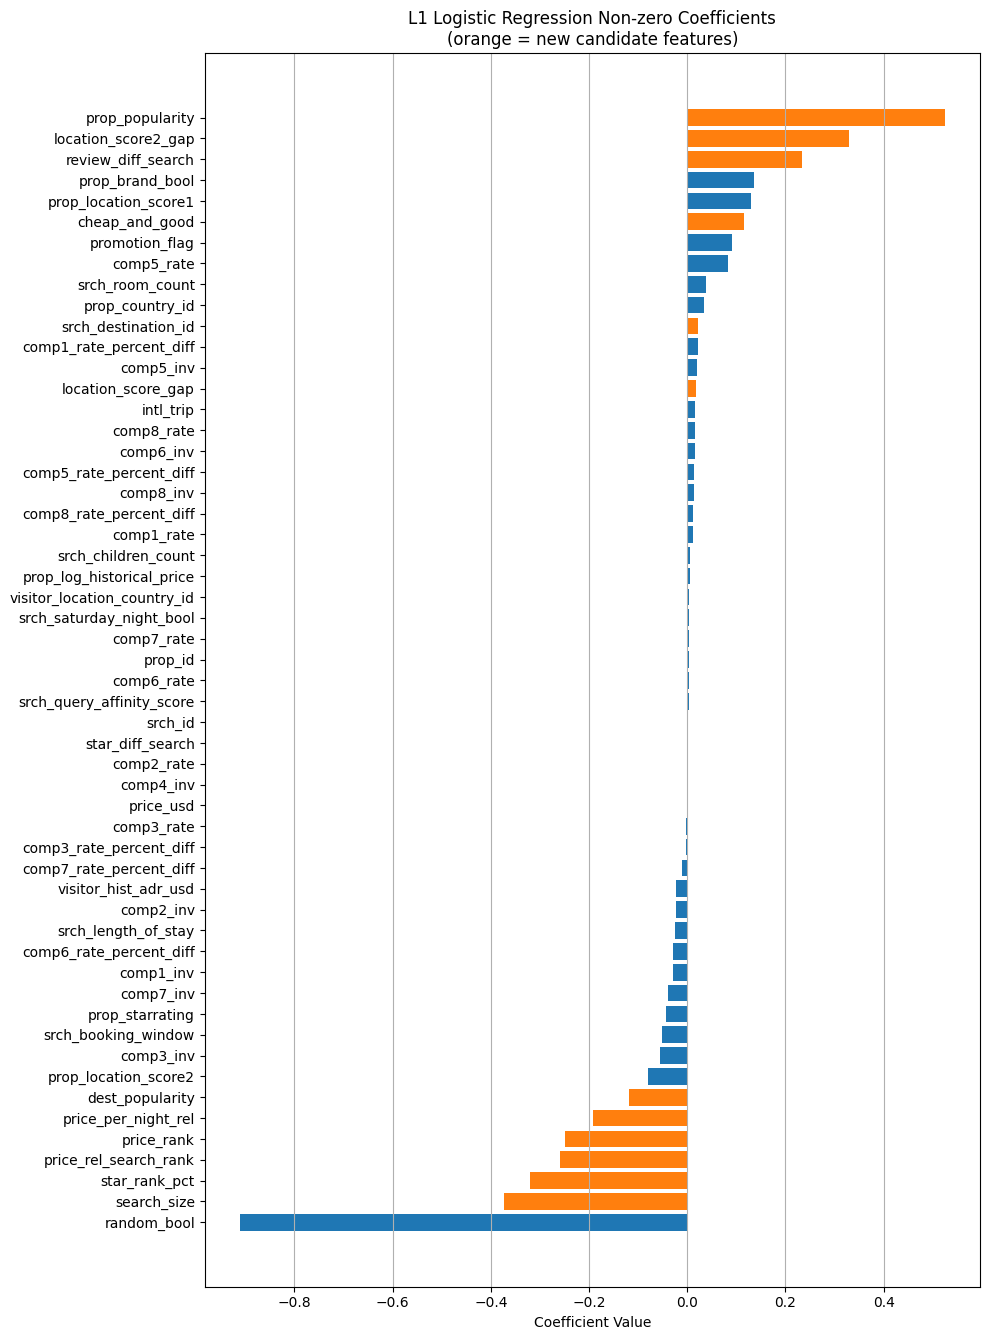

In [9]:
from sklearn.metrics import roc_auc_score, log_loss
import matplotlib.pyplot as plt

# Evaluate model
auc_logreg = roc_auc_score(y_test, proba_logreg)
ll_logreg = log_loss(y_test, proba_logreg)
print(f"L1 Logistic Regression AUC: {auc_logreg:.4f}  |  LogLoss: {ll_logreg:.4f}")

# Get non-zero coefficients
coef = pd.Series(logreg_l1.coef_[0], index=X_train.columns)
coef_nonzero = coef[coef != 0].sort_values()

# Plot
plt.figure(figsize=(10, len(coef_nonzero) * 0.25))
colors = ['tab:orange' if feat in new_cols else 'tab:blue' for feat in coef_nonzero.index]
plt.barh(coef_nonzero.index, coef_nonzero.values, color=colors)
plt.title("L1 Logistic Regression Non-zero Coefficients\n(orange = new candidate features)")
plt.xlabel("Coefficient Value")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()
